In [1]:
import pandas as pd
import numpy as np

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import string
from nltk.stem import PorterStemmer

In [167]:
from sklearn.feature_extraction.text import CountVectorizer

In [170]:
from wordcloud import WordCloud

In [60]:
from collections import Counter

In [69]:
import re

## Re-Hydrated Tweets Dataset

In [191]:
tweets_df = pd.read_csv("tweets.csv")
tweets_df.head()

,id,tweet,language,label
0,1286643297402920960,@senadormotoa @MinSaludCol Equivocado de princ...,es,FALSE
1,1265084253357907969,"Ian Haydon, who is participating in a vaccine ...",en,partially false
2,1270649437111672838,দাবী: ছ'চিয়েল মিডিয়াত প্ৰচাৰ হৈ থকা এখন ফটো ...,bn,FALSE
3,1252420840957730816,Gachibowli Sports Tower turns Covid hospital\n...,en,FALSE
4,1253761766787555335,"Protesters at state Capitol are chanting ""Wher...",en,FALSE


In [184]:
# Stopwords

with open('stopwords.txt', 'r') as f:
    stopwords = f.read().splitlines()

### Null Values

In [3]:
tweets_df.isna().any()

id          False
tweet        True
language     True
label       False
dtype: bool

In [4]:
tweets_df = tweets_df.dropna()

In [5]:
tweets_df.isna().any()

id          False
tweet       False
language    False
label       False
dtype: bool

In [192]:
english_tweets_df = tweets_df.loc[tweets_df['language']=='en', tweets_df.columns]
modified_tweets_df = english_tweets_df.copy()

modified_tweets_df['tweet'] = [tweet.replace('&amp;', '&') for tweet in modified_tweets_df['tweet']]

In [186]:
modified_tweets_df['has_links'] = modified_tweets_df['tweet'].apply(lambda x: "http" in x)

In [193]:
modified_tweets_df

,id,tweet,language,label
1,1265084253357907969,"Ian Haydon, who is participating in a vaccine ...",en,partially false
3,1252420840957730816,Gachibowli Sports Tower turns Covid hospital\n...,en,FALSE
4,1253761766787555335,"Protesters at state Capitol are chanting ""Wher...",en,FALSE
5,1237777021742338049,"🚨 BREAKING 🚨\n\n""We have therefore made the as...",en,unproven
6,1270081492908216320,1/2\n\n@WHO recently published a summary of tr...,en,FALSE
...,...,...,...,...
1688,1276629360212979712,What does a mask do? Blocks respiratory drople...,en,TRUE
1689,1240417970666369024,I don’t think people have fully digested this ...,en,TRUE
1690,1254353083355799554,The main argument I'm getting against my prior...,en,partially false
1692,1238215769445388288,I feel like this is the video that perfectly d...,en,FALSE


We have decided to filter out the dataset to only consider tweets written in English. When the filtering was done, there was 862 tweets for the training set.

In [194]:
#manually remove certain unimportant words from the tweets
new_tweets = list()
for tweet in modified_tweets_df['tweet']:
    terms = tweet.split()
    new_terms = list()
    for term in terms:
        term = term.lower()
        term = term.translate(str.maketrans('', '', string.punctuation))
        if len(term) <= 0:
            continue
        if term[0] == '@':
            continue
        if term.find('http') >= 0:
            continue
        if term in string.punctuation:
            continue
        try:
            #remove terms that are just numbers
            float(term)
        except:
            pass
        else:
            continue
        if term in stopwords or term in ['coronavirus', 'covid', 'covid-19', 'covid19']:
            continue
        
        new_terms.append(term)
        #new_terms.append(PorterStemmer().stem(term))
    new_tweets.append(' '.join(new_terms))
modified_tweets_df['tweet'] = new_tweets

true_index = modified_tweets_df[english_tweets_df['label']=='TRUE'].index
false_index = modified_tweets_df[english_tweets_df['label']=='FALSE'].index

num_true = len(true_index)
num_false = len(false_index)
num_each = min(100, num_true, num_false)

true_index = true_index[random.sample(range(num_true), num_each)]
false_index = false_index[random.sample(range(num_true), num_each)]

equal_counts_df = pd.concat([modified_tweets_df.loc[true_index], modified_tweets_df.loc[false_index]])

In [195]:
modified_tweets_df

,id,tweet,language,label
1,1265084253357907969,ian haydon participating vaccine trial feels “...,en,partially false
3,1252420840957730816,gachibowli sports tower turns hospital 14story...,en,FALSE
4,1253761766787555335,protesters state capitol chanting flag pointin...,en,FALSE
5,1237777021742338049,🚨 breaking 🚨 assessment characterized pandemic...,en,unproven
6,1270081492908216320,published summary transmission incl symptomati...,en,FALSE
...,...,...,...,...
1688,1276629360212979712,mask blocks respiratory droplets coming mouth ...,en,TRUE
1689,1240417970666369024,don’t people fully digested shocking fact disc...,en,TRUE
1690,1254353083355799554,main argument prior three statistics tweets ca...,en,partially false
1692,1238215769445388288,feel video perfectly depicts we’ve civilized s...,en,FALSE


In [196]:
# removing emoticons
rem_emoticon = re.compile(r'\W+')
modified_tweets_df['tweet'] = modified_tweets_df['tweet'].apply(lambda x: rem_emoticon.sub(' ', x))

In [197]:
modified_tweets_df['tweet'] = modified_tweets_df['tweet'].apply(lambda x: x.strip())

### Label Distribution

In [198]:
modified_tweets_df.label.unique()

array(['partially false', 'FALSE', 'unproven', 'others', 'TRUE'],
      dtype=object)

In [86]:
modified_tweets_df.label.value_counts()

FALSE              630
partially false    162
TRUE                35
others              26
unproven             9
Name: label, dtype: int64

Text(0, 0.5, 'Count')

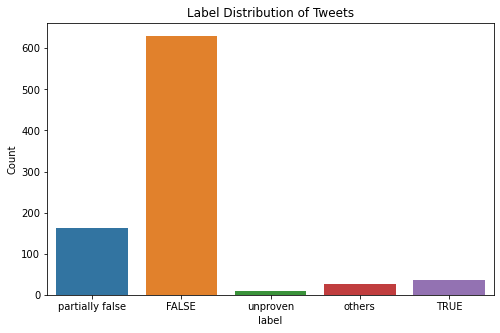

In [27]:
plt.figure(figsize=(8, 5))
sns.countplot(modified_tweets_df.label)
plt.title("Label Distribution of Tweets")
plt.ylabel("Count")

### Word Counts

In [199]:
modified_tweets_df["word_count"] = modified_tweets_df['tweet'].apply(lambda x: len(x.split()))

In [200]:
modified_tweets_df["word_count"]

1       18
3       17
4       15
5        4
6       13
        ..
1688    24
1689    22
1690    18
1692    14
1694    21
Name: word_count, Length: 862, dtype: int64

Text(0.5, 1.0, 'Average Word Count by Label')

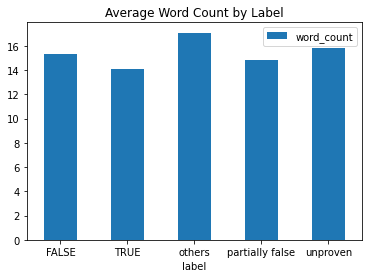

In [201]:
ax = modified_tweets_df[['word_count', 'label']].groupby(by = "label").mean().plot(kind="bar")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title("Average Word Count by Label")

## Link

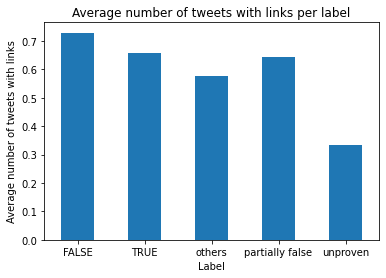

In [159]:
link_counts = modified_tweets_df.groupby('label')['has_links'].mean()
link_counts.plot(kind='bar')
plt.xlabel('Label')
plt.xticks(rotation=0)
plt.ylabel('Average number of tweets with links')
plt.title('Average number of tweets with links per label')
plt.show()

## Polarity

In [202]:
from textblob import TextBlob
modified_tweets_df['polarity']=modified_tweets_df['tweet'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [203]:
modified_tweets_df

,id,tweet,language,label,word_count,polarity
1,1265084253357907969,ian haydon participating vaccine trial feels t...,en,partially false,18,0.075000
3,1252420840957730816,gachibowli sports tower turns hospital 14story...,en,FALSE,17,-0.050000
4,1253761766787555335,protesters state capitol chanting flag pointin...,en,FALSE,15,0.000000
5,1237777021742338049,breaking assessment characterized pandemicdrte...,en,unproven,4,0.000000
6,1270081492908216320,published summary transmission incl symptomati...,en,FALSE,13,0.000000
...,...,...,...,...,...,...
1688,1276629360212979712,mask blocks respiratory droplets coming mouth ...,en,TRUE,24,0.000000
1689,1240417970666369024,don t people fully digested shocking fact disc...,en,TRUE,22,-0.500000
1690,1254353083355799554,main argument prior three statistics tweets ca...,en,partially false,18,0.041667
1692,1238215769445388288,feel video perfectly depicts we ve civilized s...,en,FALSE,14,0.455556


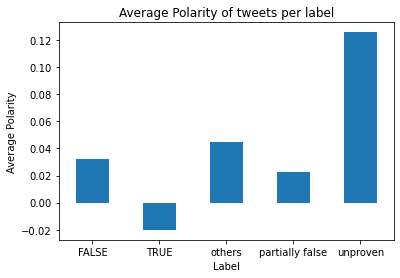

In [204]:
pol = modified_tweets_df.groupby('label')['polarity'].mean()
pol.plot(kind='bar')
plt.xlabel('Label')
plt.xticks(rotation=0)
plt.ylabel('Average Polarity')
plt.title('Average Polarity of tweets per label')
plt.show()

## KMeans Clustering Analysis

In [180]:
vectorizer = TfidfVectorizer(stop_words='english')
all_tfidf = vectorizer.fit_transform(modified_tweets_df['tweet'].to_numpy())
equal_counts_tfidf = vectorizer.fit_transform(equal_counts_df['tweet'].to_numpy())

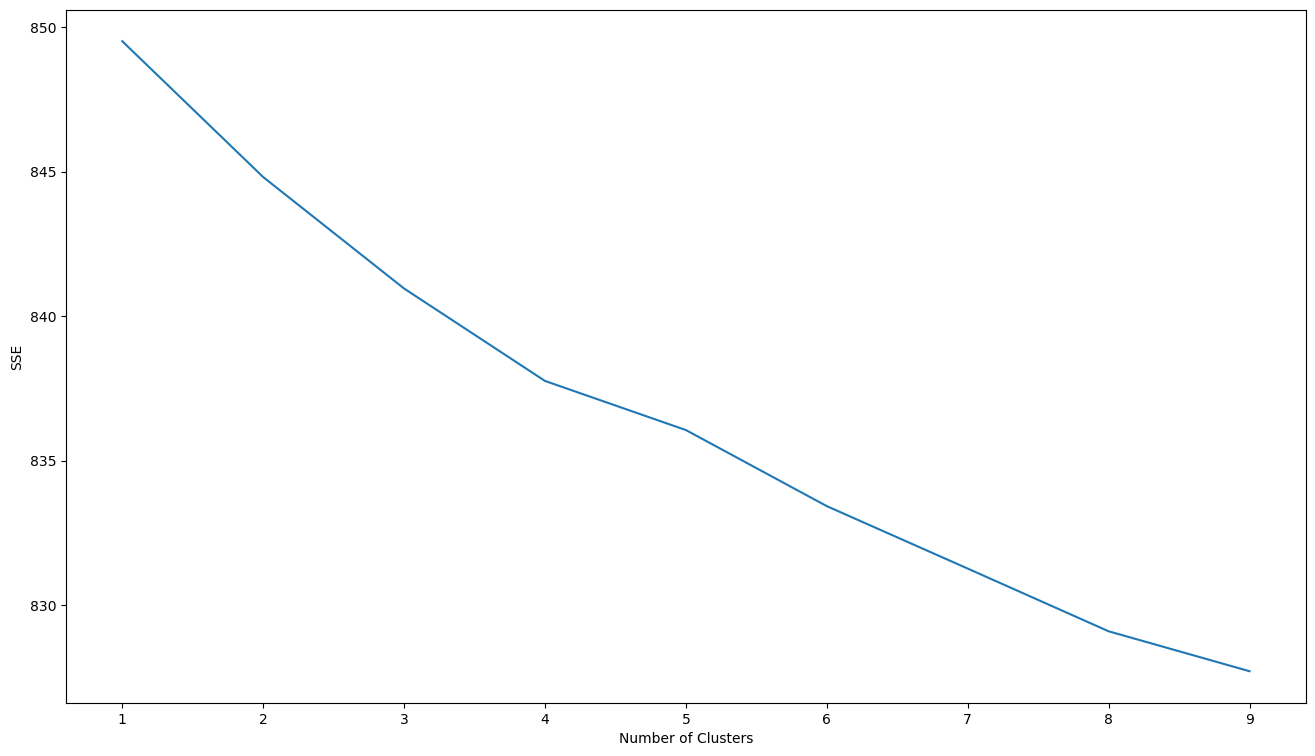

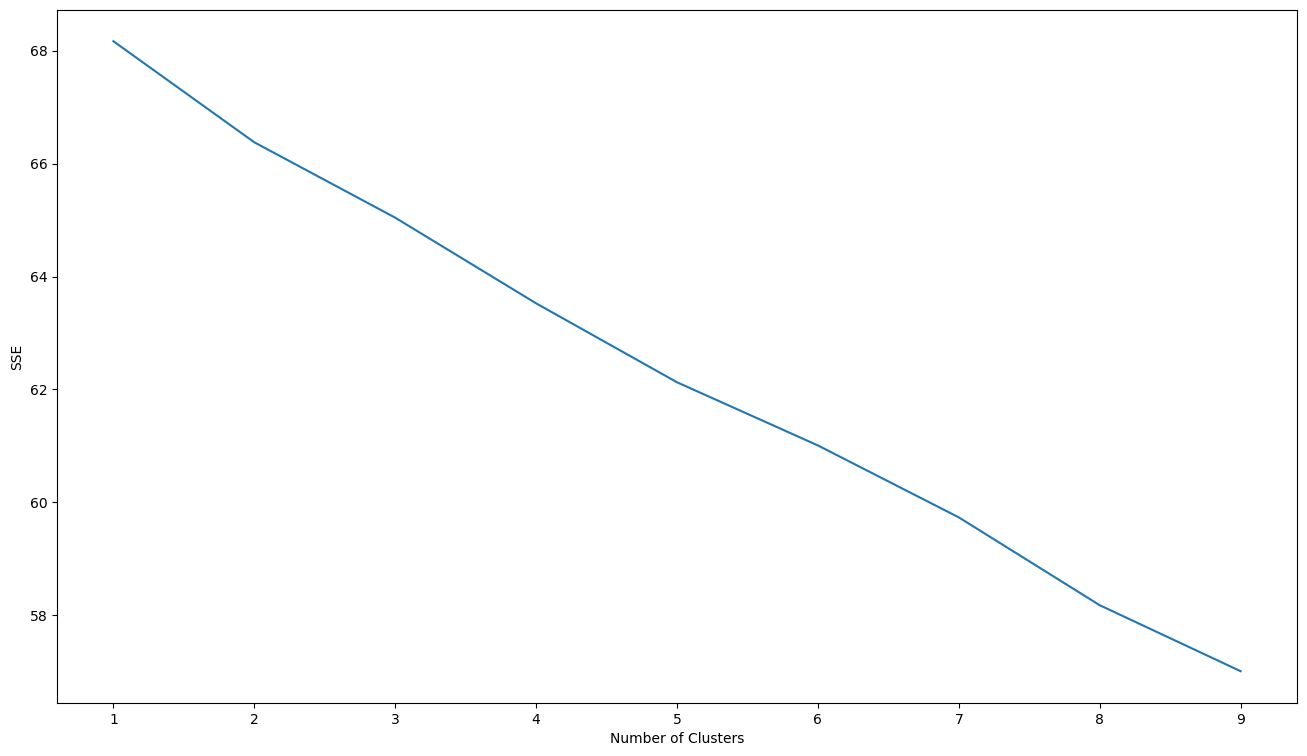

In [181]:
cluster_count = range(1,10)
sse_vals_all = np.zeros(len(cluster_count))
sse_vals_equal = np.zeros(len(cluster_count))

for index, k in enumerate(cluster_count):
    sse_vals_all[index] = KMeans(n_clusters=k, n_init=20).fit(all_tfidf).inertia_

for index, k in enumerate(cluster_count):
    sse_vals_equal[index] = KMeans(n_clusters=k, n_init=20).fit(equal_counts_tfidf).inertia_
    
plt.close()
plt.figure(figsize=(16,9))
sns.lineplot(x=cluster_count, y=sse_vals_all)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

plt.close()
plt.figure(figsize=(16,9))
sns.lineplot(x=cluster_count, y=sse_vals_equal)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

## Word Cloud

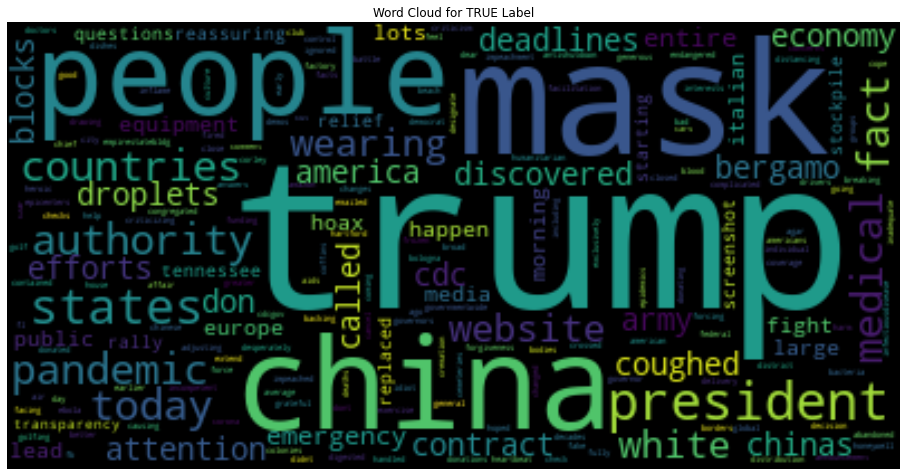

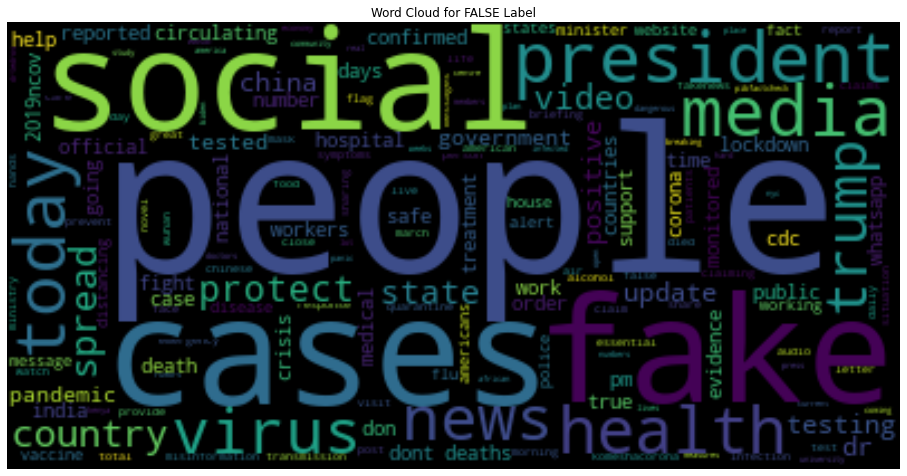

In [205]:
vectorizer = CountVectorizer(stop_words='english')
true_counts = vectorizer.fit_transform(modified_tweets_df.loc[english_tweets_df['label']=='TRUE', 'tweet'].to_numpy())
true_terms = vectorizer.get_feature_names()
true_term_count = len(true_terms)
false_counts = vectorizer.fit_transform(modified_tweets_df.loc[english_tweets_df['label']=='FALSE', 'tweet'].to_numpy())
false_terms = vectorizer.get_feature_names()
false_term_count = len(false_terms)

true_frequencies = {k:v for k,v in zip(true_terms, np.array(true_counts.sum(axis=0)).reshape(true_term_count))}
false_frequencies = {k:v for k,v in zip(false_terms, np.array(false_counts.sum(axis=0)).reshape(false_term_count))}

for name, dataset in zip(['TRUE Label', 'FALSE Label'],[true_frequencies, false_frequencies]):
    wordcloud = WordCloud().generate_from_frequencies(dataset)
    plt.close()
    plt.figure(figsize=(16,9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {name}')
    plt.axis('off')
    plt.show()